# Anomaly Detection for Prometheus Metrics Using LSTM, Isolation Forest, and Prophet

This notebook retrieves time-series data from Prometheus, preprocesses it, and applies three anomaly detection techniques:

1. **LSTM Autoencoder**: Learns normal patterns and detects anomalies based on reconstruction error.
2. **Isolation Forest**: Uses random partitioning to isolate anomalies in an ensemble approach.
3. **Prophet**: A Facebook forecasting model that identifies anomalies by comparing actual values to predicted forecast intervals.

The notebook compares anomalies detected by each method during a specified test period.

## 1. Imports

Imports required libraries, including `prophet` for the Prophet model. Suppresses common warnings for cleaner output.

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet # Added for Prophet
import warnings

# Ignore specific warnings if needed
# warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.layers.rnn.rnn')
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress Prophet/Pandas future warnings
warnings.filterwarnings("ignore", category=UserWarning) # Suppress some TF/Keras UserWarnings

# Ensure plots appear inline in Jupyter
%matplotlib inline

2025-04-21 16:39:19.239218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 16:39:19.239888: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 16:39:19.242986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-21 16:39:19.251458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745253559.265664   15695 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745253559.26

In [2]:
# --- Prometheus & Data Fetching ---
PROMETHEUS_URL = 'http://localhost:9090' # Adjust if your Prometheus is elsewhere
METRIC_COUNT = 'http_server_requests_seconds_count'
METRIC_SUM = 'http_server_requests_seconds_sum'
METRIC_MAX = 'http_server_requests_seconds_max'
FETCH_HOURS = 4 # How many hours of data to fetch
QUERY_STEP = '60s' # Resolution of the data (e.g., '60s', '5m')

# --- LSTM Configuration ---
SEQ_LEN = 30 # Sequence length (lookback window) for LSTM
TRAIN_SPLIT_RATIO = 0.8 # Proportion of data for training (LSTM & IF)
LSTM_EPOCHS = 10
LSTM_BATCH_SIZE = 32
LSTM_VALIDATION_SPLIT = 0.1 # Proportion of training data used for validation during LSTM training
ANOMALY_THRESHOLD_PERCENTILE = 95 # Percentile of reconstruction error to use as LSTM threshold

# --- Isolation Forest Configuration ---
IFOREST_CONTAMINATION = 'auto' # Expected proportion of outliers ('auto' or float e.g., 0.05)

# --- Prophet Configuration ---
PROPHET_INTERVAL_WIDTH = 0.99 # Confidence interval width for Prophet anomaly detection (e.g., 0.95, 0.99)
PROPHET_TARGET_METRIC = METRIC_COUNT # Which metric Prophet will analyze (must be one of the fetched metrics)

# --- General ---
RANDOM_STATE = 42 # For reproducibility of Isolation Forest


In [3]:
def fetch_prometheus_metric(metric_name, start_time, end_time, step='60s'):
    """Fetches metric data from Prometheus."""
    url = f'{PROMETHEUS_URL}/api/v1/query_range'
    params = {
        'query': metric_name,
        'start': int(start_time.timestamp()),
        'end': int(end_time.timestamp()),
        'step': step
    }
    print(f"Fetching {metric_name}...")
    try:
        res = requests.get(url, params=params, timeout=30) # Added timeout
        res.raise_for_status() # Raise an exception for bad status codes
        data = res.json()
        if data['status'] == 'success' and data['data']['result']:
            if not data['data']['result'][0]['values']: # Check if values list is empty
                 print(f"Warning: No data points returned for metric {metric_name} in the time range.")
                 # Return empty DF with correct columns/index type
                 return pd.DataFrame(columns=['timestamp', metric_name]).astype({'timestamp':'datetime64[ns]', metric_name:'float'}).set_index('timestamp')
            values = data['data']['result'][0]['values']
            df = pd.DataFrame(values, columns=['timestamp', metric_name])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
            df[metric_name] = df[metric_name].astype(float)
            print(f" -> Fetched {len(df)} points.")
            return df.set_index('timestamp')
        else:
            print(f"Warning: No data returned for metric {metric_name}. Status: {data.get('status')}, Data: {data.get('data')}")
            return pd.DataFrame(columns=['timestamp', metric_name]).astype({'timestamp':'datetime64[ns]', metric_name:'float'}).set_index('timestamp')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching Prometheus data for {metric_name}: {e}")
        return pd.DataFrame(columns=['timestamp', metric_name]).astype({'timestamp':'datetime64[ns]', metric_name:'float'}).set_index('timestamp')
    except Exception as e:
        print(f"An unexpected error occurred while processing {metric_name}: {e}")
        return pd.DataFrame(columns=['timestamp', metric_name]).astype({'timestamp':'datetime64[ns]', metric_name:'float'}).set_index('timestamp')



## 4. Data Fetching and Initial Preparation

Fetches specified metrics from Prometheus for the defined time range and combines them into a single Pandas DataFrame. Initializes placeholder variables for later use.

In [4]:
def create_sequences(data, seq_len):
    """Creates overlapping sequences for LSTM input."""
    X, y = [], []
    # Ensure we don't go out of bounds: loop up to len(data) - seq_len - 1
    # because y is data[i+seq_len]
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len]) # Input sequence
        y.append(data[i+seq_len])   # Target value (the one after the sequence)
    if not X: # Handle case where data is too short
        print("Warning: Not enough data points to create any sequences.")
        return np.array([]), np.array([])
    return np.array(X), np.array(y)


## 5. Preprocessing for LSTM and Isolation Forest

- Scales the data using `MinMaxScaler`.
- Creates sequences for the LSTM model.
- Splits the data into training and testing sets.
- Identifies the actual timestamps corresponding to the test set (`y_test`).

In [5]:
print("Fetching data from Prometheus...")
end_time = datetime.now()
start_time = end_time - timedelta(hours=FETCH_HOURS)

count_df = fetch_prometheus_metric(METRIC_COUNT, start_time, end_time, step=QUERY_STEP)
sum_df = fetch_prometheus_metric(METRIC_SUM, start_time, end_time, step=QUERY_STEP)
max_df = fetch_prometheus_metric(METRIC_MAX, start_time, end_time, step=QUERY_STEP)

# Combine into one DataFrame, dropping rows with any missing values
# (often happens if one metric has slightly different timestamps)
df = pd.concat([count_df, sum_df, max_df], axis=1).dropna()

# Initialize anomaly timestamp lists and model/data variables
lstm_anomaly_timestamps = pd.DatetimeIndex([])
iforest_anomaly_timestamps = pd.DatetimeIndex([])
prophet_anomaly_timestamps = pd.DatetimeIndex([])
X_train, y_train, X_test, y_test = None, None, None, None
scaled_data = None
model = None # Initialize LSTM model variable
test_timestamps = pd.DatetimeIndex([]) # Timestamps corresponding to y_test

if df.empty:
    print("\nERROR: No data fetched or combined DataFrame is empty after dropna(). Check Prometheus connection, metric names, and time range.")
    # Stop execution if no data? Or let subsequent steps handle None values? Let's let them handle it.
else:
    print(f"\nData fetched and combined successfully. Shape: {df.shape}")
    print("Latest data points (original):")
    print(df.tail())

Fetching data from Prometheus...
Fetching http_server_requests_seconds_count...
 -> Fetched 241 points.
Fetching http_server_requests_seconds_sum...
 -> Fetched 241 points.
Fetching http_server_requests_seconds_max...
 -> Fetched 241 points.

Data fetched and combined successfully. Shape: (241, 3)
Latest data points (original):
                     http_server_requests_seconds_count  \
timestamp                                                 
2025-04-21 16:35:20                             14065.0   
2025-04-21 16:36:20                             14065.0   
2025-04-21 16:37:20                             14065.0   
2025-04-21 16:38:20                             14065.0   
2025-04-21 16:39:20                             14088.0   

                     http_server_requests_seconds_sum  \
timestamp                                               
2025-04-21 16:35:20                         10.025580   
2025-04-21 16:36:20                         10.025580   
2025-04-21 16:37:20         

In [6]:
if not df.empty:
    print("\nPreprocessing data for LSTM/IF...")
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    print(f"Data scaled. Shape: {scaled_data.shape}")

    # Create sequences for LSTM using the scaled data
    X, y = create_sequences(scaled_data, SEQ_LEN)

    if X.size == 0 or y.size == 0 : # Check if sequence creation yielded data
        print(f"ERROR: Not enough data points ({len(scaled_data)}) to create sequences of length {SEQ_LEN}.")
        # Reset relevant variables to prevent errors later
        X, y = None, None
        X_train, y_train, X_test, y_test = None, None, None, None
        scaled_data = None # Can't proceed without sequences
    else:
        print(f"Sequences created. Shape of X: {X.shape}, Shape of y: {y.shape}")

        # Split sequence data for LSTM training and testing
        train_size = int(TRAIN_SPLIT_RATIO * len(X))
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        # --- Determine the timestamps corresponding to the test set (y_test) ---
        # y_test contains the targets for X_test.
        # The first target y_test[0] corresponds to the original data point at index train_size + SEQ_LEN
        test_start_index = train_size + SEQ_LEN
        test_end_index = test_start_index + len(y_test) # Calculate end index based on y_test length

        if test_start_index < len(df) and test_end_index <= len(df):
            test_timestamps = df.index[test_start_index:test_end_index]
            # Sanity check lengths
            if len(test_timestamps) != len(y_test):
                 print(f"WARNING: Length mismatch between calculated test_timestamps ({len(test_timestamps)}) and y_test ({len(y_test)}). This should not happen. Adjusting test_timestamps.")
                 # Adjust test_timestamps to match y_test length (less safe, investigate if this occurs)
                 test_timestamps = test_timestamps[:len(y_test)]

            print(f"\nData Split:")
            print(f"  Total original data points: {len(df)}")
            print(f"  Total sequences created: {len(X)}")
            print(f"  Train sequences (X_train): {len(X_train)}")
            print(f"  Test sequences (X_test): {len(X_test)}")
            print(f"  Test targets (y_test): {len(y_test)}")
            if not test_timestamps.empty:
                 print(f"  Test Timestamps range: {test_timestamps.min()} to {test_timestamps.max()} (Count: {len(test_timestamps)})")
            else:
                 print("  Test Timestamps: Could not be determined.")

        else:
            print(f"Warning: Calculated test timestamp indices ({test_start_index}:{test_end_index}) are out of bounds for the original DataFrame (length {len(df)}). Cannot determine test timestamps accurately.")
            test_timestamps = pd.DatetimeIndex([]) # Ensure it's empty
            # If we can't get test timestamps, we can't reliably compare across models later.
            # We might need to stop or adjust test set size. For now, proceed but expect comparison issues.
            if len(y_test) > 0:
                 print(f"Warning: y_test has length {len(y_test)} but corresponding timestamps could not be mapped.")


else:
    print("\nSkipping Preprocessing as input DataFrame is empty.")



Preprocessing data for LSTM/IF...
Data scaled. Shape: (241, 3)
Sequences created. Shape of X: (211, 30, 3), Shape of y: (211, 3)

Data Split:
  Total original data points: 241
  Total sequences created: 211
  Train sequences (X_train): 168
  Test sequences (X_test): 43
  Test targets (y_test): 43
  Test Timestamps range: 2025-04-21 15:57:20 to 2025-04-21 16:39:20 (Count: 43)


## 6. Build LSTM Model

Defines the LSTM autoencoder architecture, designed to reconstruct input sequences.

In [7]:
if X_train is not None and y_train is not None and X_train.shape[0] > 0 and X_train.shape[2] > 0:
    print("\nBuilding LSTM model...")
    model = Sequential([
        LSTM(64, input_shape=(SEQ_LEN, X_train.shape[2]), return_sequences=True), # Input shape uses X_train dimensions
        Dropout(0.2),
        LSTM(32, return_sequences=False), # Last LSTM layer before Dense usually doesn't return sequences
        Dropout(0.2),
        Dense(X_train.shape[2]) # Output layer should have same number of features as input
    ])
    model.compile(optimizer='adam', loss='mse') # Use Mean Squared Error for reconstruction loss
    print(model.summary())
else:
    print("\nSkipping LSTM model building: No valid training data (X_train).")
    model = None # Ensure model is None if not built



Building LSTM model...


2025-04-21 16:39:20.782664: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

None


## 7. Train LSTM Model

Trains the LSTM model on the training sequences and plots the training and validation loss.


Training LSTM model...
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
LSTM Training finished.


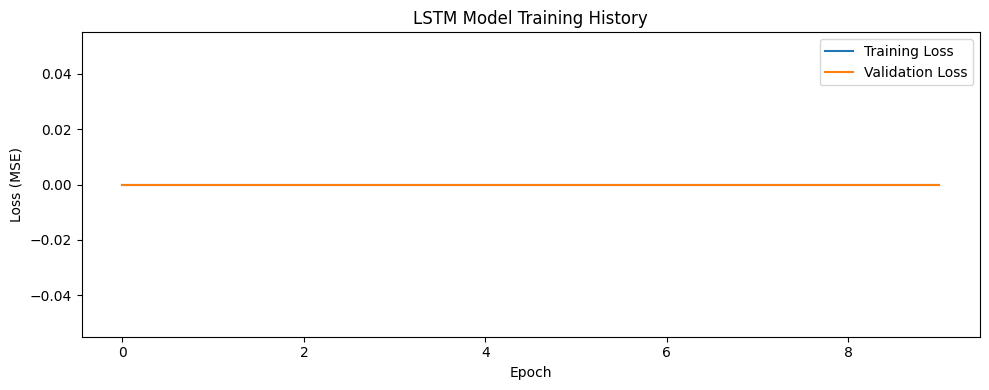

In [8]:
if model is not None and X_train is not None and y_train is not None and len(X_train)>0:
    print("\nTraining LSTM model...")
    history = model.fit(X_train, y_train,
                      epochs=LSTM_EPOCHS,
                      batch_size=LSTM_BATCH_SIZE,
                      validation_split=LSTM_VALIDATION_SPLIT,
                      shuffle=False, # Keep order for time series validation split
                      verbose=1)
    print("LSTM Training finished.")

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\nSkipping LSTM training: Model not built or no training data.")


## 8. LSTM Prediction and Anomaly Detection

- Uses the trained LSTM model to predict (reconstruct) the test sequences.
- Computes the Mean Absolute Error (MAE) between predictions and actual test targets.
- Sets an anomaly threshold based on the percentile of reconstruction errors.
- Identifies timestamps where the error exceeds the threshold.
- Plots the reconstruction errors and the anomaly threshold over time.


Predicting with LSTM model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predictions shape: (43, 3)
Reconstruction errors calculated. Shape: (43,)
Mapped 1 LSTM anomalies to timestamps.

--- LSTM Anomaly Detection Results ---
Calculated LSTM Anomaly Threshold (P95): 0.0000
Number of anomalies detected by LSTM in the test period: 1
LSTM Detected anomalies at:
DatetimeIndex(['2025-04-21 16:39:20'], dtype='datetime64[ns]', name='timestamp', freq=None)


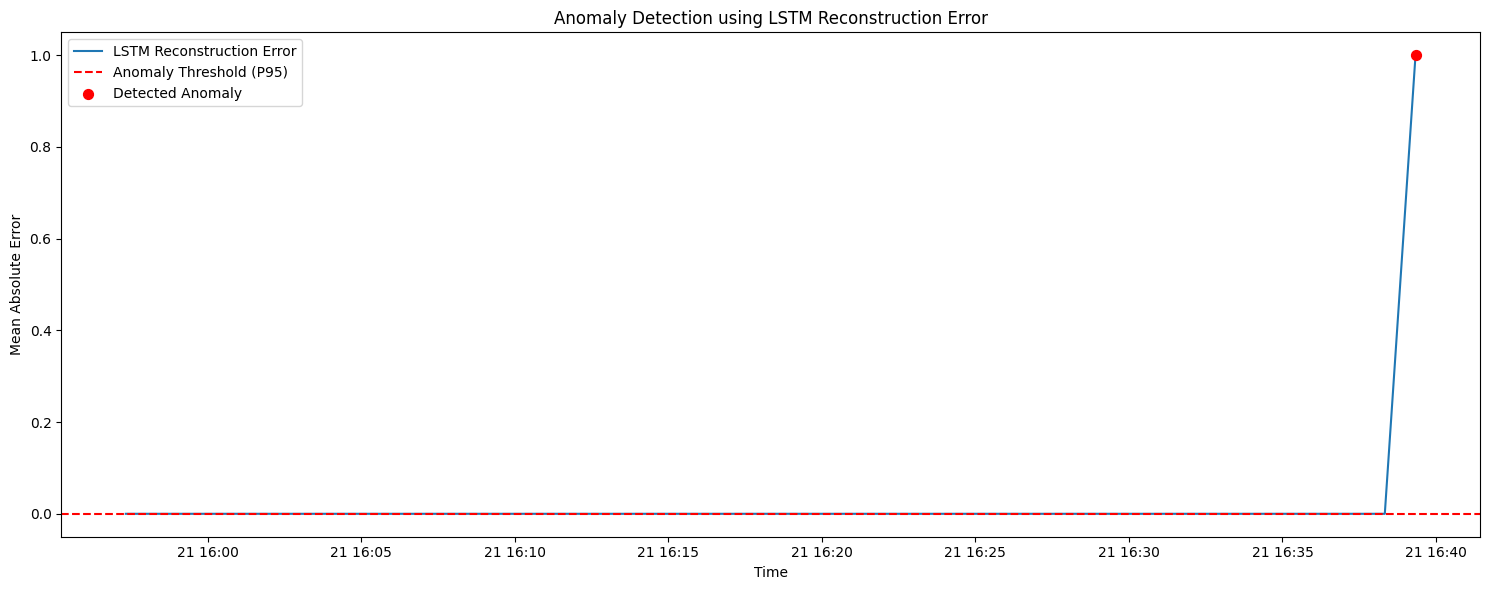

In [9]:
if model is not None and X_test is not None and y_test is not None and len(X_test) > 0:
    print("\nPredicting with LSTM model...")
    preds_lstm = model.predict(X_test)
    print(f"Predictions shape: {preds_lstm.shape}")

    # Compute LSTM reconstruction error (MAE) for each test sample
    errors_lstm = np.mean(np.abs(preds_lstm - y_test), axis=1)
    print(f"Reconstruction errors calculated. Shape: {errors_lstm.shape}")

    # Calculate threshold for LSTM anomalies
    threshold_lstm = np.percentile(errors_lstm, ANOMALY_THRESHOLD_PERCENTILE)

    # Identify LSTM anomalies where error > threshold
    anomalies_lstm_bool = errors_lstm > threshold_lstm

    # Get timestamps for LSTM anomalies using the test_timestamps index
    if not test_timestamps.empty and len(test_timestamps) == len(anomalies_lstm_bool):
        lstm_anomaly_timestamps = test_timestamps[anomalies_lstm_bool]
        print(f"Mapped {anomalies_lstm_bool.sum()} LSTM anomalies to timestamps.")
    else:
         print(f"Warning: Mismatch or absence of test_timestamps ({len(test_timestamps)}) vs LSTM anomaly results ({len(anomalies_lstm_bool)}). Cannot accurately map LSTM anomalies.")
         lstm_anomaly_timestamps = pd.DatetimeIndex([]) # Ensure empty

    print(f"\n--- LSTM Anomaly Detection Results ---")
    print(f"Calculated LSTM Anomaly Threshold (P{ANOMALY_THRESHOLD_PERCENTILE}): {threshold_lstm:.4f}")
    print(f"Number of anomalies detected by LSTM in the test period: {len(lstm_anomaly_timestamps)}")
    if not lstm_anomaly_timestamps.empty:
        print("LSTM Detected anomalies at:")
        print(lstm_anomaly_timestamps)
    else:
        print("LSTM Detected anomalies at: None")


    # Plot LSTM results
    if not test_timestamps.empty and len(test_timestamps) == len(errors_lstm):
        plt.figure(figsize=(15, 6))
        plt.plot(test_timestamps, errors_lstm, label='LSTM Reconstruction Error', zorder=1) # Use timestamps on x-axis
        plt.axhline(y=threshold_lstm, color='r', linestyle='--', label=f'Anomaly Threshold (P{ANOMALY_THRESHOLD_PERCENTILE})', zorder=2)
        # Highlight anomalies
        if not lstm_anomaly_timestamps.empty:
            plt.scatter(lstm_anomaly_timestamps.to_pydatetime(), errors_lstm[anomalies_lstm_bool], color='red', s=50, label='Detected Anomaly', zorder=3)
        plt.title('Anomaly Detection using LSTM Reconstruction Error')
        plt.xlabel('Time')
        plt.ylabel('Mean Absolute Error')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping LSTM error plot due to timestamp mismatch or empty test set.")

else:
    print("\nSkipping LSTM prediction and anomaly detection: Model not trained or no test data.")
    lstm_anomaly_timestamps = pd.DatetimeIndex([]) # Ensure empty


## 9. Isolation Forest Training and Prediction

- **Training Data**: Uses scaled data points corresponding to the *targets* of the LSTM training sequences (from index `SEQ_LEN` to `train_size + SEQ_LEN`), aligning with the LSTM's learned "normal" patterns.
- **Test Data**: Uses the scaled `y_test` data (target values for the test period) to classify as normal or anomalous.
- Fits the Isolation Forest model.
- Predicts anomalies (-1) on the test data.
- Maps predictions to corresponding timestamps.
- Optionally plots anomaly scores.


--- Isolation Forest Anomaly Detection ---
Isolation Forest training data shape: (168, 3) (Points from index 30 to 197 of scaled_data)
Isolation Forest test data shape: (43, 3)
Training Isolation Forest model...
Calculating anomaly scores using decision_function...
Scores calculated. Shape: (43,)
Note: Using estimated percentile 10.0% for threshold calculation due to 'auto' contamination.
Calculated Score Threshold: -0.0000
Identified 0 anomalies based on score < threshold.
Mapped 0 IF anomalies (score < threshold) to timestamps.

--- Isolation Forest Results (Score-based) ---
Number of anomalies detected by Isolation Forest (Score < Threshold): 0
Isolation Forest Detected anomalies at: None


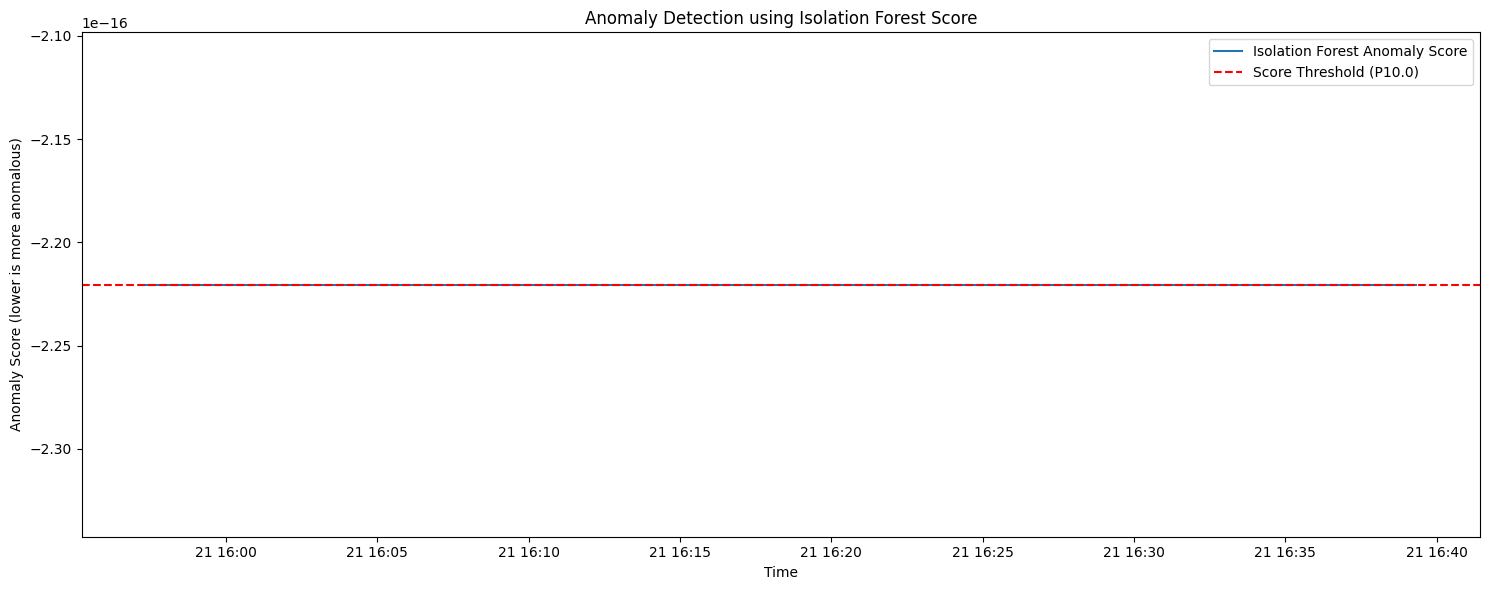

In [10]:
print("\n--- Isolation Forest Anomaly Detection ---")

iforest_train_data = None
iforest_test_data = y_test # Use the scaled *target* values from the test split
anomalies_iforest_bool = np.array([]) # Initialize as empty boolean array
scores_iforest = np.array([]) # Initialize scores array
score_threshold_iforest = None # Initialize threshold

# Determine the slice of the original scaled_data that corresponds to the *targets* used during LSTM training
if scaled_data is not None and 'train_size' in locals() and train_size > 0 and SEQ_LEN >= 0:
    iforest_train_start_idx = SEQ_LEN
    iforest_train_end_idx = train_size + SEQ_LEN

    if iforest_train_start_idx < len(scaled_data) and iforest_train_end_idx <= len(scaled_data):
         iforest_train_data = scaled_data[iforest_train_start_idx:iforest_train_end_idx]
         print(f"Isolation Forest training data shape: {iforest_train_data.shape} (Points from index {iforest_train_start_idx} to {iforest_train_end_idx-1} of scaled_data)")
    else:
        print(f"Warning: Calculated IF training indices ({iforest_train_start_idx}:{iforest_train_end_idx}) out of bounds for scaled_data (length {len(scaled_data)}).")
        iforest_train_data = None # Ensure it's None if indices are bad

# Proceed only if we have valid training and test data for IF
if iforest_train_data is not None and iforest_test_data is not None and len(iforest_train_data) > 0 and len(iforest_test_data) > 0:
    print(f"Isolation Forest test data shape: {iforest_test_data.shape}")
    print("Training Isolation Forest model...")
    try:
        # Instantiate and fit Isolation Forest
        iso_forest = IsolationForest(n_estimators=100,
                                     contamination=IFOREST_CONTAMINATION, # Contamination still informs the model structure somewhat
                                     random_state=RANDOM_STATE,
                                     n_jobs=-1)

        iso_forest.fit(iforest_train_data)

        # --- Get Anomaly Scores ---
        # Use decision_function: lower scores are more anomalous
        if hasattr(iso_forest, "decision_function"):
             print("Calculating anomaly scores using decision_function...")
             scores_iforest = iso_forest.decision_function(iforest_test_data)
             print(f"Scores calculated. Shape: {scores_iforest.shape}")

             # --- Determine Threshold based on Percentile ---
             # Get the contamination setting to determine the percentile for the threshold
             init_contamination = iso_forest.get_params()['contamination']
             contamination_level_for_percentile = 0.1 # Default fallback

             if isinstance(init_contamination, str) and init_contamination == 'auto':
                 # Use a default percentile (e.g., 10th percentile for 10% contamination) if 'auto'
                 contamination_level_for_percentile = 0.1
                 print(f"Note: Using estimated percentile {contamination_level_for_percentile*100}% for threshold calculation due to 'auto' contamination.")
             elif isinstance(init_contamination, float):
                 contamination_level_for_percentile = init_contamination
                 print(f"Note: Using contamination level {contamination_level_for_percentile*100}% for threshold percentile calculation.")
             else:
                 print(f"Warning: Unexpected contamination type '{type(init_contamination)}'. Using {contamination_level_for_percentile*100}% for threshold percentile.")

             if len(scores_iforest) > 0:
                 # Threshold is the score at the (contamination * 100)th percentile
                 score_threshold_iforest = np.percentile(scores_iforest, contamination_level_for_percentile * 100)
                 print(f"Calculated Score Threshold: {score_threshold_iforest:.4f}")

                 # --- Identify Anomalies based on Score Threshold ---
                 anomalies_iforest_bool = scores_iforest < score_threshold_iforest
                 print(f"Identified {anomalies_iforest_bool.sum()} anomalies based on score < threshold.")

             else:
                 print("Warning: No scores available to calculate threshold or identify anomalies.")
                 anomalies_iforest_bool = np.array([]) # Ensure empty

        else:
             print("Warning: Isolation Forest model does not have decision_function. Cannot use score-based threshold.")
             # Fallback maybe? Or just leave anomalies empty. Let's leave empty.
             anomalies_iforest_bool = np.array([])


        # Get timestamps for Isolation Forest anomalies using the test_timestamps index
        if not test_timestamps.empty and len(test_timestamps) == len(anomalies_iforest_bool):
            iforest_anomaly_timestamps = test_timestamps[anomalies_iforest_bool]
            print(f"Mapped {len(iforest_anomaly_timestamps)} IF anomalies (score < threshold) to timestamps.")
        else:
             print(f"Warning: Mismatch or absence of test_timestamps ({len(test_timestamps)}) vs IF anomaly results ({len(anomalies_iforest_bool)}). Cannot accurately map IF anomalies.")
             iforest_anomaly_timestamps = pd.DatetimeIndex([]) # Ensure empty

        print(f"\n--- Isolation Forest Results (Score-based) ---")
        print(f"Number of anomalies detected by Isolation Forest (Score < Threshold): {len(iforest_anomaly_timestamps)}")
        if not iforest_anomaly_timestamps.empty:
            print("Isolation Forest Detected anomalies at:")
            print(iforest_anomaly_timestamps)
        else:
             print("Isolation Forest Detected anomalies at: None")

        # --- Plot Isolation Forest scores and Threshold ---
        if score_threshold_iforest is not None and len(scores_iforest) > 0:
             if not test_timestamps.empty and len(test_timestamps) == len(scores_iforest):
                plt.figure(figsize=(15, 6))
                plt.plot(test_timestamps, scores_iforest, label='Isolation Forest Anomaly Score', zorder=1) # Use timestamps

                # Plot the calculated threshold line
                threshold_label = f'Score Threshold (P{contamination_level_for_percentile*100:.1f})'
                plt.axhline(y=score_threshold_iforest, color='r', linestyle='--', label=threshold_label, zorder=2)

                # Highlight anomalies (points below the threshold line)
                if not iforest_anomaly_timestamps.empty:
                     # Select scores corresponding to the boolean mask
                     anomaly_scores = scores_iforest[anomalies_iforest_bool]
                     plt.scatter(iforest_anomaly_timestamps.to_pydatetime(), anomaly_scores,
                                 color='red', s=50, label='Detected Anomaly (Score < Threshold)', zorder=3)

                plt.title('Anomaly Detection using Isolation Forest Score')
                plt.xlabel('Time')
                plt.ylabel('Anomaly Score (lower is more anomalous)')
                plt.legend()
                plt.tight_layout()
                plt.show()
             else:
                 print("Skipping IF score plot due to timestamp mismatch or empty test set.")
        else:
            print("Skipping IF score plot as threshold could not be determined.")

    except ValueError as e:
        print(f"Error during Isolation Forest fitting or score calculation: {e}")
        print("This might happen if the training data has insufficient variance or samples.")
        iforest_anomaly_timestamps = pd.DatetimeIndex([])
        anomalies_iforest_bool = np.array([])
    except Exception as e:
        print(f"An unexpected error occurred in Isolation Forest: {e}")
        iforest_anomaly_timestamps = pd.DatetimeIndex([])
        anomalies_iforest_bool = np.array([])
else:
    print("Skipping Isolation Forest: Prerequisite data (scaled_data/train_data/test_data) is missing or empty.")
    iforest_anomaly_timestamps = pd.DatetimeIndex([])
    anomalies_iforest_bool = np.array([]) # Ensure empty

## 10. Prophet Analysis

- Prepares data for Prophet, requiring `ds` (timestamp) and `y` (value) columns, using the *original*, unscaled data for the specified `PROPHET_TARGET_METRIC`.
- Fits the Prophet model to the entire dataset.
- Generates predictions with uncertainty intervals (`yhat_lower`, `yhat_upper`).
- Identifies anomalies where the actual value `y` falls outside the uncertainty intervals.
- Filters anomalies to include only those within the defined *test period* (`test_timestamps`) for consistent comparison.
- Plots the forecast, actual values, and detected anomalies.


--- Prophet Anomaly Detection ---
Preparing data for Prophet using original (unscaled) metric: http_server_requests_seconds_count
Prophet input data shape: (241, 2)
Plotting raw data used for Prophet:


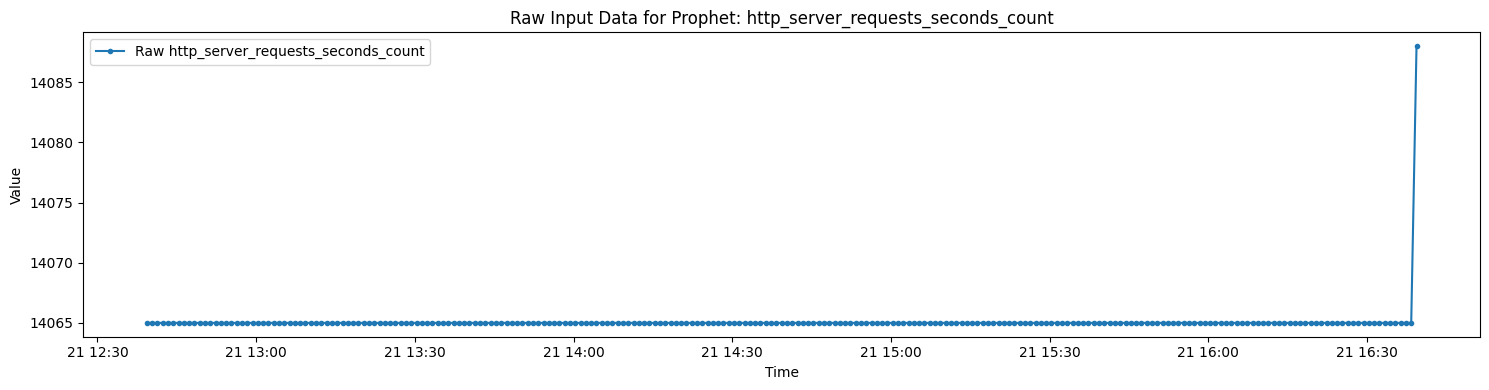

16:39:25 - cmdstanpy - INFO - Chain [1] start processing
16:39:25 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...
Using interval_width: 0.95
Predicting with Prophet model...

Sample of Prophet results (first 5 rows):
                   ds        y          yhat    yhat_lower    yhat_upper  \
0 2025-04-21 12:39:20  14065.0  14064.952032  14062.167442  14067.872139   
1 2025-04-21 12:40:20  14065.0  14064.964655  14062.327570  14067.484683   
2 2025-04-21 12:41:20  14065.0  14064.977277  14062.272883  14067.789684   
3 2025-04-21 12:42:20  14065.0  14064.989900  14062.312203  14067.715231   
4 2025-04-21 12:43:20  14065.0  14065.002522  14062.379581  14067.760547   

          trend  
0  14064.952032  
1  14064.964655  
2  14064.977277  
3  14064.989900  
4  14065.002522  

Sample of Prophet results (last 5 rows):
                     ds        y          yhat    yhat_lower    yhat_upper  \
236 2025-04-21 16:35:20  14065.0  14066.497313  14063.729483  14069.414131   
237 2025-04-21 16:36:20  14065.0  14066.545717  14063.665279  14069.433192   
238 2025-04-21 16:37:20  14065

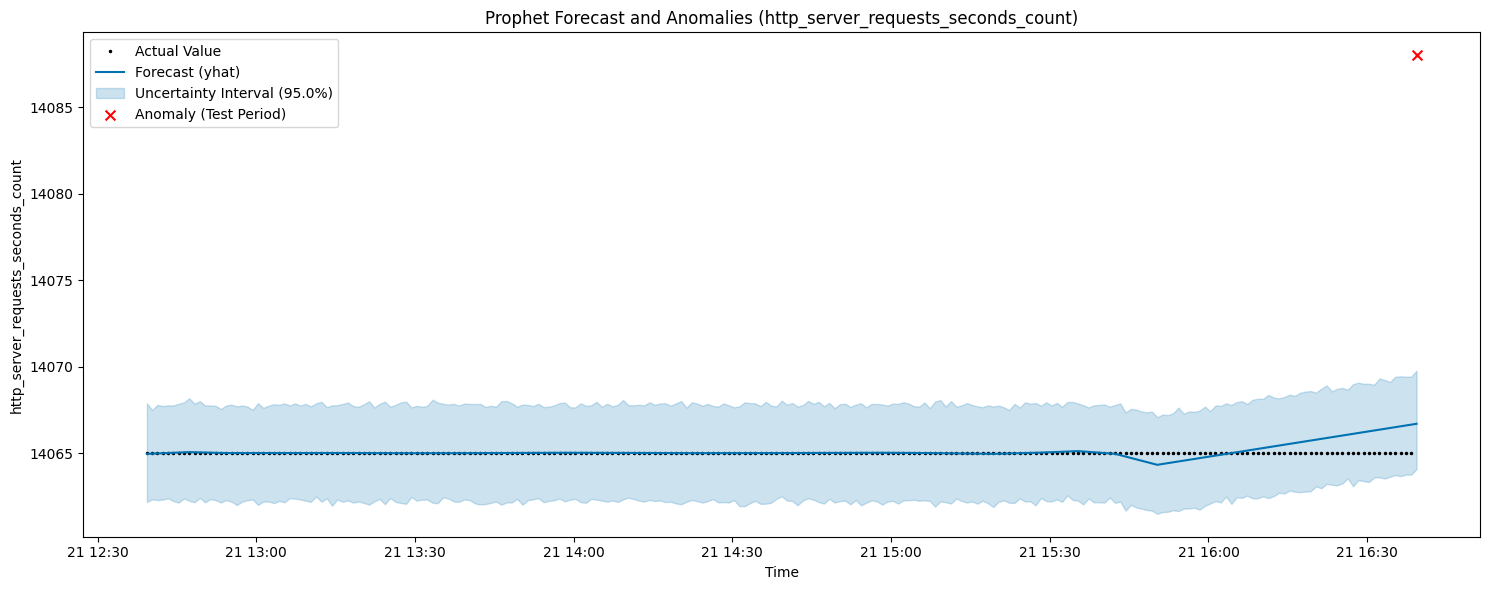


Plotting Prophet components (Trend, Seasonality)...


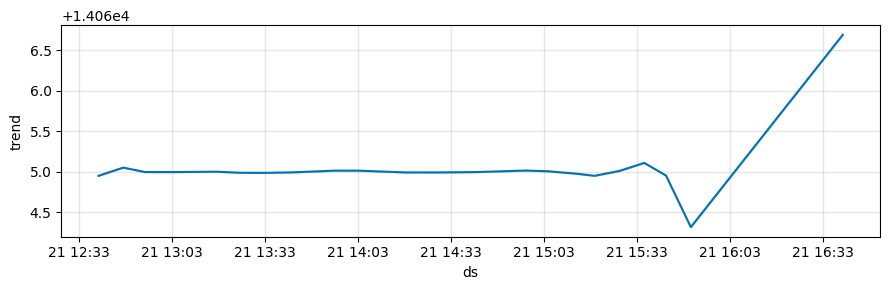

In [11]:

print("\n--- Prophet Anomaly Detection ---")

# Check if the original DataFrame and the target metric column exist
if not df.empty and PROPHET_TARGET_METRIC in df.columns:
    print(f"Preparing data for Prophet using original (unscaled) metric: {PROPHET_TARGET_METRIC}")
    prophet_df_prep = df[[PROPHET_TARGET_METRIC]].reset_index()
    prophet_df_prep.rename(columns={'timestamp': 'ds', PROPHET_TARGET_METRIC: 'y'}, inplace=True)
    print(f"Prophet input data shape: {prophet_df_prep.shape}")

    # --- DIAGNOSTIC: Plot raw Prophet input data ---
    print("Plotting raw data used for Prophet:")
    plt.figure(figsize=(15, 4))
    plt.plot(prophet_df_prep['ds'], prophet_df_prep['y'], marker='.', linestyle='-', label=f"Raw {PROPHET_TARGET_METRIC}")
    plt.title(f"Raw Input Data for Prophet: {PROPHET_TARGET_METRIC}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # --- END DIAGNOSTIC ---

    try:
        print("Training Prophet model...")
        # --- Try a potentially smaller interval width ---
        # Let's try 0.95 instead of 0.99 to see if it makes the interval tighter
        current_interval_width = 0.95 # ADJUST THIS (e.g., back to 0.99 or try 0.90)
        print(f"Using interval_width: {current_interval_width}")
        # ---

        prophet_model = Prophet(interval_width=current_interval_width, # Use the adjusted width
                                yearly_seasonality='auto',
                                weekly_seasonality='auto',
                                daily_seasonality='auto')

        prophet_model.fit(prophet_df_prep)

        print("Predicting with Prophet model...")
        forecast = prophet_model.predict(prophet_df_prep[['ds']])

        results_prophet = pd.merge(prophet_df_prep, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']], on='ds', how='left')

        # --- DIAGNOSTIC: Examine forecast values ---
        print("\nSample of Prophet results (first 5 rows):")
        print(results_prophet.head())
        print("\nSample of Prophet results (last 5 rows):")
        print(results_prophet.tail())
        print("\nDescriptive statistics of key Prophet columns:")
        print(results_prophet[['y', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].describe())
        # Calculate interval width
        results_prophet['interval_range'] = results_prophet['yhat_upper'] - results_prophet['yhat_lower']
        print("\nDescriptive statistics of the uncertainty interval range:")
        print(results_prophet['interval_range'].describe())
        # --- END DIAGNOSTIC ---


        results_prophet['anomaly'] = (results_prophet['y'] < results_prophet['yhat_lower']) | \
                                     (results_prophet['y'] > results_prophet['yhat_upper'])

        anomalies_prophet_all = results_prophet[results_prophet['anomaly']]
        num_total_prophet_anomalies = len(anomalies_prophet_all)

        prophet_anomalies_test_period_df = pd.DataFrame()
        if not test_timestamps.empty:
            print(f"\nFiltering {num_total_prophet_anomalies} Prophet anomalies to the test period ({test_timestamps.min()} to {test_timestamps.max()})")
            prophet_anomalies_test_period_df = results_prophet[results_prophet['ds'].isin(test_timestamps) & results_prophet['anomaly']]
            prophet_anomaly_timestamps = pd.DatetimeIndex(prophet_anomalies_test_period_df['ds'])

            # --- DIAGNOSTIC: Show points *within* the test period that were *not* anomalies ---
            non_anomalies_test_period = results_prophet[results_prophet['ds'].isin(test_timestamps) & ~results_prophet['anomaly']]
            if not non_anomalies_test_period.empty:
                 print(f"\nExample points in test period NOT flagged as anomalies (showing up to 5):")
                 print(non_anomalies_test_period[['ds', 'y', 'yhat_lower', 'yhat_upper', 'yhat']].head())
            # --- END DIAGNOSTIC ---

        else:
            print("\nWarning: Test timestamps are not defined. Cannot filter Prophet anomalies to the test period.")
            prophet_anomaly_timestamps = pd.DatetimeIndex([])


        print(f"\n--- Prophet Results ---")
        print(f"Number of anomalies detected by Prophet (total dataset): {num_total_prophet_anomalies}")
        print(f"Number of anomalies detected by Prophet IN THE TEST PERIOD: {len(prophet_anomaly_timestamps)}")
        if not prophet_anomaly_timestamps.empty:
            print("Prophet Detected anomalies in test period at:")
            print(prophet_anomaly_timestamps)
        else:
            print("Prophet Detected anomalies in test period at: None")

        print("\nPlotting Prophet results...")
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(results_prophet['ds'].dt.to_pydatetime(), results_prophet['y'], 'k.', label='Actual Value', ms=3)
        ax.plot(results_prophet['ds'].dt.to_pydatetime(), results_prophet['yhat'], ls='-', c='#0072B2', label='Forecast (yhat)')
        ax.fill_between(results_prophet['ds'].dt.to_pydatetime(), results_prophet['yhat_lower'], results_prophet['yhat_upper'],
                        color='#0072B2', alpha=0.2, label=f'Uncertainty Interval ({current_interval_width*100}%)') # Use current width in label
        if not prophet_anomalies_test_period_df.empty:
             ax.scatter(prophet_anomalies_test_period_df['ds'].dt.to_pydatetime(), prophet_anomalies_test_period_df['y'],
                        color='red', label='Anomaly (Test Period)', s=50, marker='x', zorder=3)
        ax.set_title(f'Prophet Forecast and Anomalies ({PROPHET_TARGET_METRIC})')
        ax.set_xlabel('Time')
        ax.set_ylabel(PROPHET_TARGET_METRIC)
        ax.legend()
        plt.tight_layout()
        plt.show()

        try:
            print("\nPlotting Prophet components (Trend, Seasonality)...")
            fig_comp = prophet_model.plot_components(forecast)
            plt.show()
        except Exception as plot_err:
            print(f"Could not plot Prophet components: {plot_err}") # Often fails if data span too short for seasonality


    except Exception as e:
        print(f"\nAn error occurred during Prophet analysis: {e}")
        prophet_anomaly_timestamps = pd.DatetimeIndex([])

else:
    print(f"\nSkipping Prophet analysis: Input DataFrame is empty or target metric '{PROPHET_TARGET_METRIC}' not found.")
    prophet_anomaly_timestamps = pd.DatetimeIndex([])

## 11. Comparison Summary

Compares anomalies detected by each method within the defined test period. Identifies timestamps flagged as anomalous by all three methods and by pairs of methods.

In [12]:
print("\n--- Comparison Summary (Anomalies in Test Period) ---")

# Use .tolist() for potentially cleaner printing of timestamps if desired, or just print the index
print(f"\nAnomalies detected by LSTM ({len(lstm_anomaly_timestamps)}):")
print(lstm_anomaly_timestamps if not lstm_anomaly_timestamps.empty else "None")

print(f"\nAnomalies detected by Isolation Forest ({len(iforest_anomaly_timestamps)}):")
print(iforest_anomaly_timestamps if not iforest_anomaly_timestamps.empty else "None")

print(f"\nAnomalies detected by Prophet ({len(prophet_anomaly_timestamps)}):")
print(prophet_anomaly_timestamps if not prophet_anomaly_timestamps.empty else "None")

# Find common anomalies
common_anomalies_all = pd.DatetimeIndex([])
common_lstm_if = pd.DatetimeIndex([])
common_lstm_prophet = pd.DatetimeIndex([])
common_if_prophet = pd.DatetimeIndex([])

# Check if timestamps are available and non-empty for comparison
can_compare_lstm = not lstm_anomaly_timestamps.empty
can_compare_if = not iforest_anomaly_timestamps.empty
can_compare_prophet = not prophet_anomaly_timestamps.empty

models_compared = []
if can_compare_lstm: models_compared.append("LSTM")
if can_compare_if: models_compared.append("Isolation Forest")
if can_compare_prophet: models_compared.append("Prophet")

print(f"\nModels with detected anomalies in test period: {', '.join(models_compared) if models_compared else 'None'}")

if len(models_compared) >= 2:
    print("\nPairwise Common Anomalies:")
    base_index = pd.DatetimeIndex([]) # Start with empty
    if can_compare_lstm:
        base_index = lstm_anomaly_timestamps
        if can_compare_if:
            common_lstm_if = base_index.intersection(iforest_anomaly_timestamps)
            print(f"- Common(LSTM, IF): {len(common_lstm_if)} {'timestamps' if len(common_lstm_if) > 0 else ''}")
            if len(common_lstm_if) > 0: print(common_lstm_if)
        if can_compare_prophet:
            common_lstm_prophet = base_index.intersection(prophet_anomaly_timestamps)
            print(f"- Common(LSTM, Prophet): {len(common_lstm_prophet)} {'timestamps' if len(common_lstm_prophet) > 0 else ''}")
            if len(common_lstm_prophet) > 0: print(common_lstm_prophet)

    if can_compare_if:
        base_index = iforest_anomaly_timestamps # Use IF as base now
        if can_compare_prophet:
             # Only calculate if not already done via LSTM
             if not can_compare_lstm: # If LSTM wasn't comparable, calculate IF/Prophet here
                 common_if_prophet = base_index.intersection(prophet_anomaly_timestamps)
             elif not common_lstm_prophet.equals(common_if_prophet): # Check if it differs from LSTM/Prophet intersection
                 common_if_prophet = base_index.intersection(prophet_anomaly_timestamps)

             print(f"- Common(IF, Prophet): {len(common_if_prophet)} {'timestamps' if len(common_if_prophet) > 0 else ''}")
             if len(common_if_prophet) > 0: print(common_if_prophet)


    if len(models_compared) == 3:
        # Find intersection of all three
        common_anomalies_all = lstm_anomaly_timestamps.intersection(iforest_anomaly_timestamps).intersection(prophet_anomaly_timestamps)
        print(f"\nCommon anomalies detected by ALL THREE models ({len(common_anomalies_all)}):")
        print(common_anomalies_all if not common_anomalies_all.empty else "None")

else:
    print("\nComparison of common anomalies not possible as fewer than two models detected anomalies in the test period.")


print("\nAnalysis finished.")


--- Comparison Summary (Anomalies in Test Period) ---

Anomalies detected by LSTM (1):
DatetimeIndex(['2025-04-21 16:39:20'], dtype='datetime64[ns]', name='timestamp', freq=None)

Anomalies detected by Isolation Forest (0):
None

Anomalies detected by Prophet (1):
DatetimeIndex(['2025-04-21 16:39:20'], dtype='datetime64[ns]', name='ds', freq=None)

Models with detected anomalies in test period: LSTM, Prophet

Pairwise Common Anomalies:
- Common(LSTM, Prophet): 1 timestamps
DatetimeIndex(['2025-04-21 16:39:20'], dtype='datetime64[ns]', freq=None)

Analysis finished.
